In [85]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [86]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [87]:
def cross_val_data(data_x, data_y, num_points_per_task, total_task=10, shift=1):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]

    batch_per_task = 5000 // num_points_per_task
    sample_per_class = num_points_per_task // total_task
    test_data_slot = 100 // batch_per_task
    class_per_task = 100//total_task
    
    for task in range(total_task):
        for batch in range(batch_per_task):
            for class_no in range(task * class_per_task, (task + 1) * class_per_task, 1):
                indx = np.roll(idx[class_no], (shift - 1) * 100)

                if batch == 0 and class_no == 0 and task == 0:
                    train_x = x[
                        indx[batch * sample_per_class : (batch + 1) * sample_per_class],
                        :,
                    ]
                    train_y = y[
                        indx[batch * sample_per_class : (batch + 1) * sample_per_class]
                    ]
                    test_x = x[
                        indx[
                            batch * test_data_slot
                            + 500 : (batch + 1) * test_data_slot
                            + 500
                        ],
                        :,
                    ]
                    test_y = y[
                        indx[
                            batch * test_data_slot
                            + 500 : (batch + 1) * test_data_slot
                            + 500
                        ]
                    ]
                else:
                    train_x = np.concatenate(
                        (
                            train_x,
                            x[
                                indx[
                                    batch
                                    * sample_per_class : (batch + 1)
                                    * sample_per_class
                                ],
                                :,
                            ],
                        ),
                        axis=0,
                    )
                    train_y = np.concatenate(
                        (
                            train_y,
                            y[
                                indx[
                                    batch
                                    * sample_per_class : (batch + 1)
                                    * sample_per_class
                                ]
                            ],
                        ),
                        axis=0,
                    )
                    test_x = np.concatenate(
                        (
                            test_x,
                            x[
                                indx[
                                    batch * test_data_slot
                                    + 500 : (batch + 1) * test_data_slot
                                    + 500
                                ],
                                :,
                            ],
                        ),
                        axis=0,
                    )
                    test_y = np.concatenate(
                        (
                            test_y,
                            y[
                                indx[
                                    batch * test_data_slot
                                    + 500 : (batch + 1) * test_data_slot
                                    + 500
                                ]
                            ],
                        ),
                        axis=0,
                    )

    return train_x, train_y, test_x, test_y

In [149]:
class TaskDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.copy()
        self.y = y.copy()

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [194]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.layer1 = nn.Conv2d(in_channels=3, out_channels=16,
			kernel_size=(3, 3))
        self.bn1 = nn.BatchNorm2d(16)
        self.layer2 = nn.Conv2d(in_channels=16, out_channels=32,
			kernel_size=(3, 3), padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        self.layer3 = nn.Conv2d(in_channels=32, out_channels=64,
			kernel_size=(3, 3), padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        self.layer4 = nn.Conv2d(in_channels=64, out_channels=128,
			kernel_size=(3, 3), padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.layer5 = nn.Conv2d(in_channels=128, out_channels=254,
			kernel_size=(3, 3), padding='same')
        self.bn5 = nn.BatchNorm2d(254)
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(228600, 100)
        self.bn_linear1 = nn.BatchNorm1d(100)
        self.linear2 = nn.Linear(100, 100)
        self.bn_linear2 = nn.BatchNorm1d(100)
        self.linear3 = nn.Linear(100, latent_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(self.bn1(x))
        x = self.layer2(x)
        x = F.relu(self.bn2(x))
        x = self.layer3(x)
        x = F.relu(self.bn3(x))
        x = self.layer4(x)
        x = F.relu(self.bn4(x))
        x = self.layer5(x)
        x = F.relu(self.bn5(x))
        x = self.flatten(x)
        
        x = self.linear1(x)
        x = F.relu(self.bn_linear1(x))
        x = self.linear2(x)
        x = F.relu(self.bn_linear2(x))
        x = self.linear3(x)

        return x

In [195]:
class Head(nn.Module):
    def __init__(self, latent_dim, output, nodes=10):
        super(Head, self).__init__()
        self.layer1 = nn.Linear(latent_dim, nodes)
        self.layer2 = nn.Linear(nodes, nodes)
        self.output = nn.Linear(nodes, output)
        

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output(x)

        return x

In [196]:
class ContrastLoss(nn.Module):
    def __init__(self, latent_dim, margin=0.3, replay_const=1e-1):
        super(ContrastLoss, self).__init__()
        self.margin = margin
        self.replay_const = replay_const

    def forward(self, inputs, targets, inputs_replay, targets_replay):
        dis_embedding = torch.cdist(
                            inputs,
                            inputs,
                            p=2.0
                        )


        number_of_heads = targets.shape[1]
        kernel_partition = torch.sum(
                            targets.view(1,-1,number_of_heads)==targets.view(-1,1,number_of_heads),
                            dim=2)/number_of_heads
        
        dis_partition = (1-kernel_partition)>1e-12

        ############################################################
        dis_embedding_replay = torch.cdist(
                            inputs_replay,
                            inputs_replay,
                            p=2.0
                        )
        number_of_heads_replay = targets_replay.shape[1]
        kernel_partition_replay = torch.sum(
                            targets_replay.view(1,-1,number_of_heads_replay)==targets_replay.view(-1,1,number_of_heads_replay),
                            dim=2)/number_of_heads_replay
        
        dis_partition_replay = (1-kernel_partition_replay)>1e-12
        loss = torch.mul(
                        kernel_partition,
                        dis_embedding
                    ) + torch.clamp(torch.mul(
                        dis_partition,
                        self.margin-dis_embedding
                        ), 0.0)
        
        loss_replay = torch.mul(
                        kernel_partition_replay,
                        dis_embedding_replay
                    ) + torch.clamp(torch.mul(
                        dis_partition_replay,
                        self.margin-dis_embedding_replay
                        ), 0.0)
                
        return loss.mean() + self.replay_const*loss_replay.mean()

In [197]:
data_train = unpickle('/Users/jayantadey/contrastive_lifelong_learning/notebook_experiments/data/cifar-100-python/train')
data_test = unpickle('/Users/jayantadey/contrastive_lifelong_learning/notebook_experiments/data/cifar-100-python/test')

In [198]:
x1, y1 = data_train[b'data'], data_train[b'fine_labels']
x2, y2 = data_test[b'data'], data_test[b'fine_labels']

X_, y_ = np.concatenate((x1,x2)), np.concatenate((y1,y2))

In [199]:
X_ = X_.reshape(-1, 3, 32, 32).astype('float64')/255.0

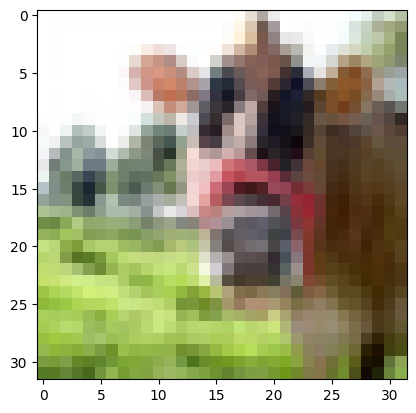

In [200]:
plt.imshow(np.transpose(X_[0], (1, 2, 0)))

In [207]:
slots = 10
shifts = 6
batch_size = 32
num_points_per_task = 500
total_task = 10
latent_dim = 5
epoch_per_task_encoder = 100
epoch_per_task_head = 200
learning_rate_encoder = 3e-4
learning_rate_head = 5e-2
margin = 4.5
replay_const = 7e-2

for shift in range(shifts):
    train_x, train_y, test_x, test_y = cross_val_data(X_, y_, num_points_per_task, total_task=total_task, shift=shift)
    for slot in range(slots):
        X_replay = []
        y_replay = []
        single_accuracies = []
        accuracies = []
        total_task_seen = 0
        heads = {}
        heads_single = {}
        encoder = Encoder(latent_dim=latent_dim)
        encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr = learning_rate_encoder, weight_decay = 1e-14)
        criterion_encoder = ContrastLoss(latent_dim, margin=margin, replay_const=replay_const)
        for task in range(total_task):
            print('Doing %d slot, %d shift, %d task'% (slot+1, shift+1, task+1) )
            
            idx_task = range(task * 5000\
                + slot * num_points_per_task, task * 5000\
                + (slot + 1) * num_points_per_task)

            X, y = train_x[idx_task], train_y[idx_task]
            y = y.reshape(-1,1)
            
            train_loader = DataLoader(TaskDataset(X, y), batch_size=batch_size, shuffle=True) 

            if task == 0:
                X_replay = X
            else:
                X_replay = torch.cat((X_replay, X))
            
            
                with torch.no_grad():
                    embedding = encoder(X.float())
                    
                    for jj in range(total_task_seen):
                        head_predicted_label = heads[jj](embedding).argmax(1).view(-1,1)
                        y = torch.cat((y, head_predicted_label),
                                    dim=1)
        
            
            #######################
            if task == 0:
                y_replay = y
            else:
                with torch.no_grad():
                    embedding = encoder(X_replay.float())
                    
                    for jj in range(total_task_seen):
                        head_predicted_label = heads[jj](embedding).argmax(1).view(-1,1)
            
                        if jj == 0:
                            y_replay = head_predicted_label
                        else:
                            y_replay = torch.cat((y_replay, head_predicted_label),dim=1)

            replay_loader = DataLoader(TaskDataset(X_replay, y_replay), batch_size=batch_size, shuffle=True) 


            for epoch in range(epoch_per_task_encoder):
                running_loss = 0.0
        
                count = 0
                for (X__, y__), (X_r, y_r) in zip(train_loader, replay_loader):
                    encoder_optimizer.zero_grad()
                    embedding = encoder(X__.float())
                    embedding_replay = encoder(X_r.float())
                    
                    loss = criterion_encoder(embedding, y__, embedding_replay, y_r)
                    #print(X_r.shape)
                    loss.backward()
                    encoder_optimizer.step()
        
                    running_loss += loss.item()
                    count += 1
        
            print("Epoch :", epoch+1, "loss :", running_loss/(count+1))
                    
        
            ## train head ##
            heads[task] = Head(latent_dim=latent_dim, output=classes_per_task)
            head_optimizer = torch.optim.SGD(heads[task].parameters(), lr=learning_rate_head, momentum=0.9)
            criterion_head = nn.CrossEntropyLoss()
                
            for epoch in range(epoch_per_task_head):
                for X__, y__ in train_loader:
                    head_optimizer.zero_grad()
                    
                    with torch.no_grad():
                        embedding = encoder(X__.float())
        
                    predicted_y = heads[task](embedding)
                    loss_head = criterion_head(predicted_y, y__[:,0].long())
                    loss_head.backward()
                    head_optimizer.step()
                    
            print(f'head {task+1} Epoch : {epoch+1}, loss: {loss_head:.4f}')

            total_task_seen += 1

            acc = []
            for kk in range(total_task_seen):
                idx_test = range(kk * 1000, (kk + 1) * 1000)
                x_t, y_t = test_x[idx_test], test_y[idx_test]
                
                with torch.no_grad():
                    embedding = encoder(x_t)
                    head_predicted_label = heads[kk](embedding).argmax(1).view(-1,1)
    
                accuracy = torch.sum(y_t.view(-1,1)==head_predicted_label)/10000
                print(f'Task {kk+1} accuracy: ', accuracy)
                acc.append(accuracy)
            
            accuracy_multitask.append(acc)


        #######################################
        for task in range(total_task):
            print('Doing %d slot, %d shift, %d single task'% (slot+1, shift+1, task+1) )

            encoder = Encoder(latent_dim=latent_dim)
            encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr = learning_rate_encoder, weight_decay = 1e-14)
            criterion_encoder = ContrastLoss(latent_dim, margin=margin, replay_const=replay_const)
        
            idx_task = range(task * 5000\
                + slot * num_points_per_task, task * 5000\
                + (slot + 1) * num_points_per_task)

            X, y = train_x[idx_task], train_y[idx_task]
            y = y.reshape(-1,1)
            
            train_loader = DataLoader(TaskDataset(X, y), batch_size=batch_size, shuffle=True) 

            X_replay = X
            y_replay = y

            replay_loader = DataLoader(TaskDataset(X_replay, y_replay), batch_size=batch_size, shuffle=True) 


            for epoch in range(epoch_per_task_encoder):
                running_loss = 0.0
        
                count = 0
                for (X__, y__), (X_r, y_r) in zip(train_loader, replay_loader):
                    encoder_optimizer.zero_grad()
                    embedding = encoder(X__.float())
                    embedding_replay = encoder(X_r.float())
                    
                    loss = criterion_encoder(embedding, y__, embedding_replay, y_r)
                    #print(X_r.shape)
                    loss.backward()
                    encoder_optimizer.step()
        
                    running_loss += loss.item()
                    count += 1
        
            print("Epoch :", epoch+1, "loss :", running_loss/(count+1))
                    
        
            ## train head ##
            heads_single[task] = Head(latent_dim=latent_dim, output=classes_per_task)
            head_optimizer = torch.optim.SGD(heads_single[task].parameters(), lr=learning_rate_head, momentum=0.9)
            criterion_head = nn.CrossEntropyLoss()
                
            for epoch in range(epoch_per_task_head):
                for X__, y__ in train_loader:
                    head_optimizer.zero_grad()
                    
                    with torch.no_grad():
                        embedding = encoder(X__.float())
        
                    predicted_y = heads_single[task](embedding)
                    loss_head = criterion_head(predicted_y, y__[:,0].long())
                    loss_head.backward()
                    head_optimizer.step()
                    
            print(f'head {task+1} Epoch : {epoch+1}, loss: {loss_head:.4f}')


            idx_test = range(task * 1000, (task + 1) * 1000)
            x_t, y_t = test_x[idx_test], test_y[idx_test]
            
            with torch.no_grad():
                embedding = encoder(x_t)
                head_predicted_label = heads_single[task](embedding).argmax(1).view(-1,1)
    
            accuracy = torch.sum(y_t.view(-1,1)==head_predicted_label)/10000
            print(f'Task {task+1} single task accuracy: ', accuracy)
    
            single_accuracies.append(accuracy)
        
        #####
        summary = (accuracy_multitask, single_accuracies)
        
        with open('result/ConL'+ "_"+ str(shift)+ "_"+ str(slot)+ ".pickle"', 'wb') as f:
            pickle.dump(summary, f)
        

Doing 1 slot, 1 shift, 1 task



KeyboardInterrupt

[E thread_pool.cpp:112] Exception in thread pool task: mutex lock failed: Invalid argument


In [208]:
running_loss

0.6190494298934937

In [209]:
test_x.shape

(10000, 3, 32, 32)